In [9]:
import numpy as np
import matplotlib.pyplot as plt

from pyomo.core.base.objective import minimize
from pyomo.environ import ConcreteModel, AbstractModel, Var, Objective, Constraint, ConstraintList, SolverFactory
from pyomo.environ import maximize, Binary, RangeSet, Set, NonNegativeReals, Reals

In [10]:
def get_binary_string(sequence):
    binary = ""
    for amino_acid in sequence:
        if amino_acid == "H":
            binary += "1"
        elif amino_acid == "P":
            binary += "0"
        else:
            raise Exception("Invalid sequence, only 'H' and 'P' are allowed")
    return binary

In [75]:
protein_sequence = "HPHPHH"
protein_binary_sequence = get_binary_string(protein_sequence)

print("Protein sequence:", protein_sequence)
print("Protein binary sequence:", protein_binary_sequence)
n = len(protein_sequence)
print("Protein length:", n)

Protein sequence: HPHPHH
Protein binary sequence: 101011
Protein length: 6


## Basic Model
This model is from the chapter 7 of the book

In [23]:
def neighboring_set(p, n):
    grid_size = n*n
    n_set = []

    for k in range(grid_size-1):
        if k == p-1 or k == p+1 or k == p-n or k == p+n:
            n_set.append(k)
    
    return n_set

In [24]:
def get_hydrophobic_set(seq):
    hydrophobic_set = []
    for idx in range(len(seq)):
        if seq[idx] == "1":
            hydrophobic_set.append(idx)
    return hydrophobic_set

print(get_hydrophobic_set(protein_binary_sequence))

[0, 2, 5, 6]


In [25]:
def calculate_offset(seq):
    count = 0
    for i in range(len(seq) - 1):
        if seq[i] == "1" and seq[i+1] == "1":
            count += 1
    return count

print(calculate_offset(protein_binary_sequence))

1


In [76]:
def ILP_basic_formulation(binary_seq):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################

    n = len(binary_seq) # sequence length
    grid_size = n*n
    offset = calculate_offset(binary_seq)

    # Set of indices
    model.I = RangeSet(0, n - 1)    # character in the sequence index
    model.I1 = RangeSet(0, n - 2)
    model.P = RangeSet(0, grid_size - 1)    # point on grid index
    model.H = get_hydrophobic_set(binary_seq)   # set of indexes in sequence where value is 1 (hydrophobic)

    # Decision variables
    model.x = Var(model.I, model.P, within=Binary)
    model.h = Var(model.P, within=Binary)
    model.c = Var(model.P, model.P, within=Binary) 


    ###################
    #   CONSTRAINTS   #
    ###################

    model.constraints = ConstraintList()

    # Each amino acid in the sequence is assigned to exactly one point on the grid
    for i in model.I:
        model.constraints.add(expr = ( sum( model.x[i, p] for p in model.P ) == 1 ) )
    
    # Each point on the grid is assigned at most one amino acid in the sequence
    for i in model.I:
        for j in model.I:
            for p in model.P:
                if i != j:
                    model.constraints.add(expr = ( model.x[i, p] + model.x[j, p] <= 1 ) )
    
    # Adjacent amino acids in the sequence are assigned to neighboring points on the grid
    for i in model.I1:
        for p in model.P:
            model.constraints.add(expr = ( model.x[i, p] <= sum( model.x[i+1, q] for q in neighboring_set(p, n) ) ) )

    # Constraints to detect contacts, i.e. edges (p,q) on the grid where neighboring points p and q
    # have been assigned non-adiancent characters in the sequence with value 1
    for p in model.P:
        model.constraints.add(expr = ( model.h[p] == sum( model.x[i, p] for i in model.H ) ) )
    for p in model.P:
        for q in model.P:
            if p != q:
                model.constraints.add(expr = ( model.h[p] + model.h[q] >= 2*model.c[p, q] ) )

    
    ###################
    #   OBJECTIVE     #
    ###################
    model.obj = Objective(expr = ( sum( model.c[p, q] for p in model.P for q in model.P ) - offset ), sense = maximize)


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", [[model.x[i, p]() for p in model.P] for i in model.I]) 
    else:
        print('Error in solving the model')

    return [[model.x[i, p]() for p in model.P] for i in model.I]



x = ILP_basic_formulation(protein_binary_sequence)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-18
Read LP format model from file /var/folders/57/yk3w62md44z9m6ndy61mkkz80000gn/T/tmp6fue0afl.pyomo.lp
Reading time = 0.00 seconds
x1549: 2563 rows, 1549 columns, 7157 nonzeros
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2563 rows, 1549 columns and 7157 nonzeros
Model fingerprint: 0x97655fa0
Variable types: 1 continuous, 1548 integer (1548 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 47.0000000
Presolve removed 1695 rows and 687 columns
Presolve time: 0.03s
Presolved: 868 rows, 862 columns, 3252 nonzeros
Variable types: 0 continuous, 862 integer (862 binary)

Root relaxation: objective 1.750000e+02, 

[18, 12, 13, 19, 20, 14]
[[3 0]
 [2 0]
 [2 1]
 [3 1]
 [3 2]
 [2 2]]


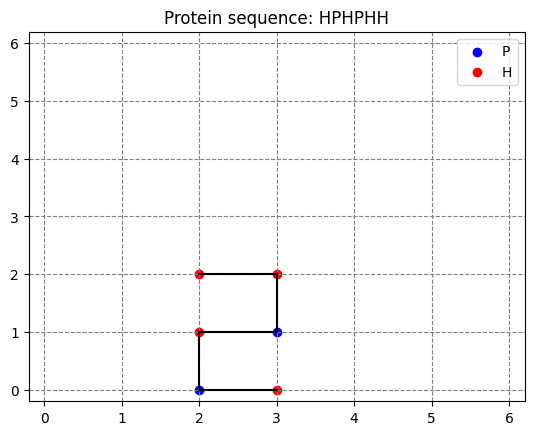

In [77]:
positions = []
pos = []
for i in range(len(x)):
    for p in range(len(x[i])):
        if x[i][p] == 1:
            positions.append((p // n, p % n))
            pos.append(p)
print(pos)
data = np.asarray(positions)
print(data)

H_set = get_hydrophobic_set(protein_binary_sequence)
P_set = list(set(np.arange(0,n)) - set(H_set))

plt.title("Protein sequence: "+protein_sequence)
plt.plot(data[:,0], data[:,1], 'black') # line segments
plt.scatter(data[P_set,0], data[P_set,1], c='b', label="P")
plt.scatter(data[H_set,0], data[H_set,1], c='r', label="H")
plt.axis([-0.2, n+0.2, -0.2, n+0.2])
plt.rc('grid', linestyle="--", color='grey')
plt.grid(True)
plt.legend()

plt.show()

## Graph Model
This model is from the paper

In [4]:
%pip install networkx
import networkx as nx


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [19]:
def is_adjacent(i, j, u, v):
    return ( u == i and abs(v-j) == 1 ) or ( v == j and abs(u-i) == 1 )

In [20]:
def build_graph(binary_seq):
    G = nx.Graph()

    n = len(binary_seq)
    grid_size = 2*n - 1

    # add nodes
    for i in range(grid_size):
        for j in range(i+1, grid_size):
                G.add_node( (i, j) )

    # add edges
    for i, j in G.nodes():
         for u, v in G.nodes():
              if is_adjacent(i, j, u, v):
                   G.add_edge( (i, j), (u, v) )
    
    return G

In [ ]:
def ILP_graph_formulation(G):
    model = ConcreteModel()

    ###################
    #   VARIABLES     #
    ###################


    ###################
    #   CONSTRAINTS   #
    ###################


    ###################
    #   OBJECTIVE     #
    ###################


    ###################
    #   SOLVER        #
    ###################
    sol = SolverFactory('gurobi').solve(model, tee=True)

    # CHECK SOLUTION STATUS

    # Get a JSON representation of the solution
    sol_json = sol.json_repn()

    if sol_json['Solver'][0]['Status'] == 'ok':
        print("Optimal solution value:", model.obj())
        print("\tValues of the decision variables:", ) 
    else:
        print('Error in solving the model')
    
    return

In [21]:
G = build_graph(protein_binary_sequence)
print(G.number_of_nodes(), G.number_of_edges())

78 132
